In [5]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import pandas as pd
from NMF import *
import utils
import IPython
from data import * 

n_fft = 512
samplerate = 16000

Audio Experiment
---

We test standard NMF and ANMF in the semi-supervised case where we only have access to clean and noisy data, but no joint information.
We use a single id from the librispeech dataset, which consists of about 8 minutes of speech. We split this into train and test sets that contain 4 minutes of speech each. We mix the test set with noise from the WHAM! dataset. We rerun the experiment for different input SNR values.

In order to repclicate:
1. Download WHAM! noise dataset (https://wham.whisper.ai/), and put the folder in the same folder as this notebook 
2. Download the clean development set of LibriSpeech (https://www.openslr.org/12), and put the folder in the same folder as this notebook named "Audio".
3. Loading of data is handled by data.py, so if something does not work, check this file.

In [13]:
# BIG EXPERIMENT
np.random.seed(1)
audio_data = audio(ids = ["1673"])
input_snrs = [-6,-3,0,3,6,9]
mu_W = 1e-10; mu_H = 1e-10
batch_size = 5000; batch_size_z = 5000
tau_A = 0.5
epochs = 50
ds = [64,64]

probs = ["semi","semi_adv"]
results = {}
results["snr"] = []
for prob in probs:
    results[prob] = []
    results["P" + prob] = []
results["oracle"] = []

mean_snrs = []
mean_sdrs = []

seps = []

for snr in input_snrs:
    beta = audio_data.generate(snr = snr, seed = 1)
    print(beta)
    speech_train = audio_data.speech_train
    speech_test = audio_data.speech_test
    noisy_test = audio_data.noisy_test
    noise_test = audio_data.noise_test
    results["snr"].append(snr)

   # Calculate oracle

    U_test = []
    Z = []
    for i in range(len(speech_test)):
        Z.append(librosa.stft(speech_test[i],n_fft=n_fft))
        U_test.append(np.abs(Z[i]))
    

    # Calculate mixed data
    V_test = []
    Z_test = []
    for i in range(len(noisy_test)):
        Z_test.append(librosa.stft(noisy_test[i],n_fft=n_fft))
        V_test.append(np.abs(Z_test[i]))

    val = 0
    for i in range(len(noisy_test)):

        speech_oracle = librosa.istft(U_test[i] * np.exp(1j * np.angle(Z_test[i])), n_fft = n_fft, length = len(speech_test[i]))
    
        val += (calculate_sdr(speech_test[i], speech_oracle))/len(noisy_test)
    
    results["oracle"].append(val)

    for prob in probs:
        np.random.seed(0)
        sep = audio_separation(ds = ds, prob = prob, tau_A = tau_A * beta, epochs = epochs,
            test_epochs = 100, mu_W = 1e-10, mu_H = 1e-10, batch_size = batch_size, batch_size_z = batch_size_z)
        sep.fit(u = speech_train, v = noisy_test)

        seps.append(sep)

        results[prob].append(sep.eval(speech_test, noisy_test, metric = "SDR"))
        sep.project = True
        results["P"+prob].append(sep.eval(speech_test, noisy_test, metric = "SDR"))


/Users/martilud/ANMF/data.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  speech_ = np.random.permutation(self.speech)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/martilud/ANMF/data.py:255: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noise_ = np.random.permutation(self.noise)
/Users

0.7094796650218077
0.8784039499336697
1.017731209941141
1.1120783820849656
1.1607485919044935
1.1725210750284554


In [14]:
print(pd.DataFrame(results))

   snr       semi      Psemi   semi_adv  Psemi_adv     oracle
0   -6   0.835528  -1.850932   1.386310   0.065276  11.591504
1   -3   3.521208   1.097886   4.232185   2.960111  13.558233
2    0   6.038069   4.020901   6.982892   5.786378  15.562695
3    3   8.433320   6.886109   9.178372   8.377613  17.619368
4    6  10.480437   9.637448  11.353796  10.719047  19.744363
5    9  12.162928  12.191063  13.087074  12.774763  21.961553


In [12]:
# Listen to speech, noise and noisy
IPython.display.display(IPython.display.Audio(speech_test[-1], rate = samplerate))
IPython.display.display(IPython.display.Audio(noise_test[-1], rate = samplerate))
IPython.display.display(IPython.display.Audio(noisy_test[-1], rate = samplerate))

In [29]:
beta = audio_data.generate(snr = 0, seed = 1)
print(beta)
speech_train = audio_data.speech_train
speech_test = audio_data.speech_test
noisy_test = audio_data.noisy_test
noise_test = audio_data.noise_test

1.017731209941141


/Users/martilud/ANMF/data.py:254: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  speech_ = np.random.permutation(self.speech)
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/martilud/ANMF/data.py:255: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noise_ = np.random.permutation(self.noise)
/Users

In [47]:
from copy import deepcopy
sep_std = deepcopy(seps[4]) # std separation trained with snr = 0

sep_adv = deepcopy(seps[5]) # adv separation trained with snr = 0

In [75]:
sep_std.project = False
sep_adv.project = False

out_std = sep_std.separate(noisy_test)
out_adv = sep_adv.separate(noisy_test)

In [76]:
# Recalculate the SDR of all data

SDR_std = []
SDR_adv = []

for i in range(len(out_std)):
    SDR_std.append(calculate_sdr(speech_test[i], out_std[i]))
    SDR_adv.append(calculate_sdr(speech_test[i], out_adv[i]))


4.020816718445742
5.787104923146007


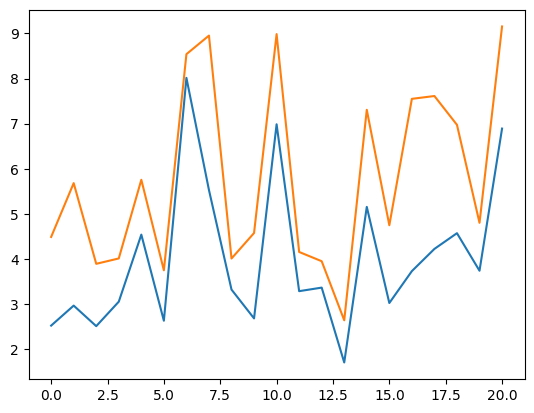

In [77]:
# Plot the different SDR
plt.plot(SDR_std)
plt.plot(SDR_adv)
print(np.mean(SDR_std))
print(np.mean(SDR_adv))

We see that ANMF outperforms NMF for basically all data.

In [78]:
ids = np.argsort(np.array(SDR_adv) - np.array(SDR_std))
diff = np.sort(np.array(SDR_adv) - np.array(SDR_std))
print(np.array(SDR_adv)[ids])
print(ids)
print(diff)

[8.540259   3.94972703 4.00958537 4.15501793 2.63963778 4.01138025
 4.80071038 3.74803857 5.75535801 3.89202    4.74706643 4.57516231
 4.48784146 8.98523437 7.30691804 9.15462628 6.97405189 5.68138273
 7.61264933 8.95242421 7.55011201]
[ 6 12  8 11 13  3 19  5  4  2 15  9  0 10 14 20 18  1 17  7 16]
[0.52468279 0.58539967 0.68868658 0.86926789 0.93513819 0.9586597
 1.06201309 1.11830472 1.21594368 1.38202909 1.72400415 1.89347581
 1.96583896 1.99919861 2.15214123 2.26404752 2.40289102 2.71592586
 3.39003173 3.42455606 3.81981594]


In [80]:
# Listen to speech, noise and noisy
print("CLEAN")
IPython.display.display(IPython.display.Audio(speech_test[ids[-1]], rate = samplerate))
print("NOISE")
IPython.display.display(IPython.display.Audio(noise_test[ids[-1]], rate = samplerate))
print("NOISY SPEECH")
IPython.display.display(IPython.display.Audio(noisy_test[ids[-1]], rate = samplerate))
print("STD DENOISE")
IPython.display.display(IPython.display.Audio(out_std[ids[-1]], rate = samplerate))
print("ADV DENOISE")
IPython.display.display(IPython.display.Audio(out_adv[ids[-1]], rate = samplerate))

CLEAN


NOISE


NOISY SPEECH


STD DENOISE


ADV DENOISE


In [72]:
import soundfile as sf
# 16 is where adversarial outperforms std by quite a lot, and the recovered signal is also relatively good. Outperforms by ~3.1 dB
# 13 adv still outperforms, but neither method performs particularily well. Std arguably sounds qulitatively better. Outperforms by ~1.6 dB

saveids = [16,13]
for id in saveids:
    sf.write('Audio/Result/clean' + str(id) + '.wav', speech_test[id], samplerate = 16000)
    sf.write('Audio/Result/noise' + str(id) + '.wav', noise_test[id], samplerate = 16000)
    sf.write('Audio/Result/noisy' + str(id) + '.wav', noisy_test[id], samplerate = 16000)
    sf.write('Audio/Result/std' + str(id) + '.wav', out_std[id], samplerate = 16000)
    sf.write('Audio/Result/adv' + str(id) + '.wav', out_adv[id], samplerate = 16000)